In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import keras
from collections import Counter
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
from textblob import TextBlob
import cufflinks as cf
import nltk
nltk.download('punkt')
!pip install keras_preprocessing
from keras_preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from keras_preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras import Input
from keras.models import Model
from keras.layers import Embedding, LSTM, concatenate, Dense


# ignoring the warnings
import warnings
warnings.filterwarnings("ignore")

def load_model():
    # Reading the train data
    train_data = pd.read_csv("train.csv")

    # Shape of dataset
    # print("\n Shape of the Train DataSet")
    # print(train_data.head())
    # print(train_data.shape)
    # print("\n Label", Counter(train_data['label']))

    print("\nNull Values", train_data.isnull().sum())

    train_data = train_data.dropna()

    print("\nAfter dropping null values")
    print(train_data.isnull().sum())

    # incase of any null data it resets its index
    train_data = train_data.copy()
    train_data.reset_index(inplace=True)



    # #wordcloud generator

    # lisst = train_data['title1_en'].tolist()
    # listToStr = ' '.join(map(str, lisst))
    # listToStr = listToStr.replace('"', '')
    # text = listToStr

    # # Create and generate a word cloud image:
    # wordcloud = WordCloud().generate(text)
    # wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    # plt.figure()
    # plt.imshow(wordcloud, interpolation="bilinear")
    # plt.axis("off")
    # plt.show()

    # lisst = train_data['title2_en'].tolist()
    # listToStr = ' '.join(map(str, lisst))
    # listToStr = listToStr.replace('"', '')

    # text = listToStr

    # # Create and generate a word cloud image:
    # wordcloud = WordCloud().generate(text)
    # wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    # plt.figure()
    # plt.imshow(wordcloud, interpolation="bilinear")
    # plt.axis("off")
    # plt.show()

    #polarity

    cf.go_offline()
    cf.set_config_file(offline=False, world_readable=True)


    train_data['polarity2'] = train_data['title2_en'].map(lambda text: TextBlob(text).sentiment.polarity)
    print(train_data['polarity2'])

    train_data['polarity1'] = train_data['title1_en'].map(lambda text: TextBlob(text).sentiment.polarity)
    print(train_data['polarity1'])

    #text based on labels
    train_data['title1_en'].str.len().hist(by=train_data['label'])
    train_data['title2_en'].str.len().hist(by=train_data['label'])

    MAX_NUM_WORDS = 2000
    MAX_SEQUENCE_LENGTH = 150

    def do_tokenization(sentence):
        word_tokens = word_tokenize(sentence)
        tokenized_words = [word_token for word_token in word_tokens if word_token.isalpha()] 
        return tokenized_words


    train_data['title2_en_tokenized'] = train_data.loc[:,'title2_en'].apply(do_tokenization)
    train_data['title1_en_tokenized'] = train_data.loc[:,'title1_en'].apply(do_tokenization)


    tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)
    corpus = pd.concat([train_data['title1_en_tokenized'], train_data['title2_en_tokenized']])
    tokenizer.fit_on_texts(corpus)

    title1 = tokenizer.texts_to_sequences(train_data['title1_en_tokenized'])
    x1_train = pad_sequences(title1,maxlen=MAX_SEQUENCE_LENGTH)

    title2 = tokenizer.texts_to_sequences(train_data['title2_en_tokenized'])
    x2_train = pad_sequences(title2,maxlen=MAX_SEQUENCE_LENGTH)

    label_to_index = {'unrelated' : 0, 'agreed' : 1, 'disagreed' : 2}

    y_train = train_data.label.apply(lambda lab : label_to_index[lab])
    y_train = np.asarray(y_train).astype('float32')

    # y_train [:10]


    y_train = keras.utils.np_utils.to_categorical(y_train)
    # y_train[:15]

    #Training and Validation Split
    from sklearn.model_selection import train_test_split 
    x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(x1_train, x2_train, y_train , test_size = 0.1 , random_state = 9527)

    NUM_LSTM_UNITS = 128
    NUM_EMBEDDING_DIM = 128


    topInput = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
    bmInput  = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')

    embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM)
    topEmbedded = embedding_layer(topInput)
    bmEmbedded = embedding_layer(bmInput)

    lstmLayer = LSTM(NUM_LSTM_UNITS)
    topOutput = lstmLayer(topEmbedded)
    bmOutput = lstmLayer(bmEmbedded)

    concatenated_layer = concatenate([topOutput, bmOutput], axis=-1)

    dense =  Dense(units=3, activation='softmax')
    predictions_data = dense(concatenated_layer)

    model = Model(inputs=[topInput, bmInput], outputs=predictions_data)
    
    return model,x1_train, x1_test, x2_train, x2_test, y_train, y_test

[nltk_data] Downloading package punkt to C:\Users\Aditya
[nltk_data]     Sarwate\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Null Values id           0
tid1         0
tid2         0
title1_en    0
title2_en    0
label        0
dtype: int64

After dropping null values
id           0
tid1         0
tid2         0
title1_en    0
title2_en    0
label        0
dtype: int64


0         0.10000
1         0.00000
2         0.15625
3         0.00000
4         0.00000
           ...   
256437    0.00000
256438   -0.18750
256439    0.00000
256440    0.20000
256441    0.00000
Name: polarity2, Length: 256442, dtype: float64
0         0.078788
1        -0.083333
2        -0.083333
3        -0.083333
4        -0.083333
            ...   
256437    0.150000
256438    0.150000
256439    0.150000
256440    0.150000
256441    0.000000
Name: polarity1, Length: 256442, dtype: float64


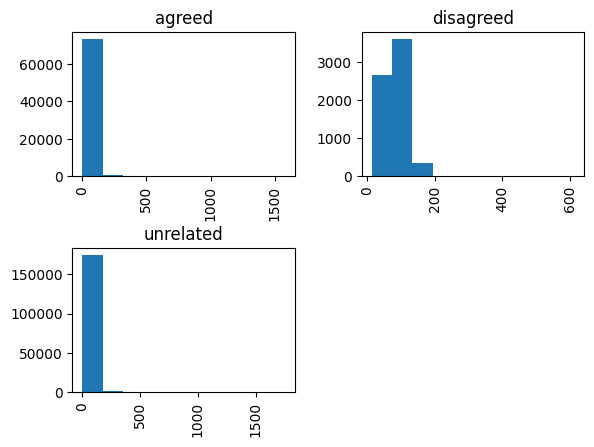

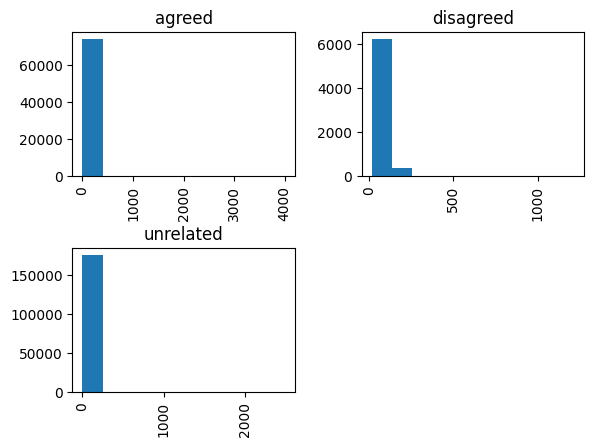

In [11]:
LSTM_Model, x1_train, x1_test, x2_train, x2_test, y_train, y_test = load_model()

In [ ]:
LSTM_Model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

BATCH_SIZE = 128
NUM_EPOCHS = 20

history = LSTM_Model.fit(x = [x1_train, x2_train], y = y_train, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, validation_data = ([x1_test, x2_test], y_test), shuffle = True)

def plot_accuracy_hists(x, y1, y2, xlabel, ylabel, label, title):
    plt.plot(x, y1,'g',label='Training ' + label)
    plt.plot(x, y2,'b',label='Valdiation ' + label)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)


    plt.legend()
    plt.show()
    
history_model_values = history.history
cnt = history.history['accuracy']
plot_accuracy_hists(range(1, len(cnt) + 1), history_model_values['loss'], history_model_values['val_loss'], 'NoOfEpochs', 'Loss', 'Training & Validation Data Loss', 'Loss')

plot_accuracy_hists(range(1, len(cnt) + 1), history_model_values['accuracy'], history_model_values['val_accuracy'], 'NoOfEpochs', 'Accuracy', 'Training & Validation Data Accuracy', 'Accuracy')

Epoch 1/20
1023/1804 [================>.............] - ETA: 50:43 - loss: 0.6068 - accuracy: 0.7066

<H1>Model Evaluation on Test data

In [68]:
test_data = pd.read_csv("test.csv")
# test_data.head(5)

x_test = test_data[['title1_en', 'title2_en']]
# x_test.head()

x_test['title1_tokenized'] = test_data.loc[:,'title1_en'].apply(do_tokenization)
x_test['title2_tokenized'] = test_data.loc[:,'title2_en'].apply(do_tokenization)

title1_temp = tokenizer.texts_to_sequences(x_test['title1_tokenized'])
x1_test = pad_sequences(title1_temp, maxlen=MAX_SEQUENCE_LENGTH)

title2_temp = tokenizer.texts_to_sequences(x_test['title2_tokenized'])
x2_test = pad_sequences(title2_temp, maxlen=MAX_SEQUENCE_LENGTH)

# len(x2_test)

data_predictions = model.predict([x1_test, x2_test])
# data_predictions[:5]

index_to_label = { v : k for k , v in label_to_index . items ()}        

test_data['label'] = [ index_to_label [ idx ] for idx in np.argmax (data_predictions, axis = 1 )]

submission_data = test_data.loc[:, ['id', 'label']]
submission_data.columns = ['id', 'label']
submission_data.to_csv('submission_69.csv', index=False)

,id,tid1,tid2,title1_en,title2_en
0,256442,100672,100673,"The great coat brother Zhu Zhu Wen, in the man...","Lin xinsheng after the birth of ""hard milking,..."
1,256443,162269,162270,NASA reveals facts about UFO wreckage found on...,"The UFO found in Yuancun, Jiaocheng County, Sh..."
2,256444,157826,157854,The hollow tomatoes are loaded with hormones.,"Li chenfan bingbing home photos, netizen: this..."
3,256445,109579,74076,Ange Pavilion Geoshui: How accurate is Matrimo...,Master one: the eight-character presumption of...
4,256446,15068,15085,A 50-year-old bus-bus blows up an 8-year-old c...,< i > Joe Johnson's disgruntled timing and ord...
